In [2]:
import os
from pathlib import Path
from collections import OrderedDict

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ['MKL_THREADING_LAYER'] = 'GNU'


import torch
import nibabel as nib # https://nipy.org/nibabel/
import SimpleITK as sitk # https://simpleitk.org/
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
import pandas as pd
from deep_staple.metrics import dice3d

from deep_staple.utils.common_utils import get_script_dir

THIS_SCRIPT_DIR = get_script_dir("")
DEVICE = 'cpu'

# View initial quality of atlas dices (after registration) for deeds and convex adam

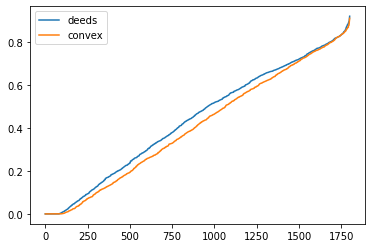

In [3]:
convex_atlases = torch.load(Path(THIS_SCRIPT_DIR, "../../data_artifacts/20220318_crossmoda_convex_adam_lr/crossmoda_convex_registered_new_convex.pth").resolve(), map_location=DEVICE)
deeds_atlases = torch.load(Path(THIS_SCRIPT_DIR, "../../data_artifacts/20220114_crossmoda_multiple_registrations/crossmoda_deeds_registered.pth").resolve(), map_location=DEVICE)

dcs_convex = []
for fixed_item in convex_atlases.values():
    for moving_item in fixed_item.values():
        dcs_convex.append(moving_item['dice'][0][1].item())
dcs_convex.sort()

dcs_deeds = []
for fixed_item in deeds_atlases.values():
    for moving_item in fixed_item.values():
        dcs_deeds.append(moving_item['dice'][0][1].item())
dcs_deeds.sort()

plt.plot(dcs_deeds, label='deeds')
plt.plot(dcs_convex, label='convex')
plt.legend()
plt.show()

# Create consensi (take training data directly and calculate consensi as well as dice values. Store data in a consistent dict)

### Pull out data of network training and put into fixed-moving dict

In [16]:
def calc_dp_consensus(lbl_list, weighting_list):
    LIMIT = .5
    label_stack = torch.stack(lbl_list)
    weightings = torch.tensor(weighting_list)
    weightings = torch.softmax(weightings, 0)
    weighted_stack = label_stack.to_dense()*weightings.view(-1,1,1,1)
    weighted_stack = weighted_stack.sum((0))
    consensus = (weighted_stack > LIMIT).long()

    return consensus


def calc_staple_consensus(lbl_list):
    staple_filter = sitk.STAPLEImageFilter()
    # sitk.ProcessObject.SetGlobalDefaultDebugOff()
    FOREGROUND = 1.0
    staple_filter.SetForegroundValue(FOREGROUND)
    staple_filter.SetMaximumIterations(200)
    sitk_moving_data = [sitk.GetImageFromArray(lbl.to_dense().numpy().astype(np.int16)) for lbl in lbl_list]
    
    staple_out = staple_filter.Execute(sitk_moving_data)
    consensus = (torch.tensor(sitk.GetArrayFromImage(staple_out)) > .5).long()
    sensitivities = staple_filter.GetSensitivity()
    specificities = staple_filter.GetSpecificity()

    return consensus, sensitivities, specificities

In [17]:
cases = ['400_deeds', '1200_deeds', '1800_deeds', '400_convex_adam', 'debug_case']
current_case = '400_convex_adam'

print(f"Creating consensus for {current_case}")

if current_case == '400_deeds':
    # Training with 400 labels (deeds)
    network_scores = torch.load(Path(THIS_SCRIPT_DIR, "../../data/output/dashing-surf-1206_fold0_epx39/train_label_snapshot.pth").resolve())

elif current_case == '400_convex_adam':
    # Training with 400 labels (convex adam)
    network_scores = torch.load(Path(THIS_SCRIPT_DIR, "../../data/output/winter-frost-32_fold0_epx39/train_label_snapshot.pth").resolve())

elif current_case == '1200_deeds':
    network_scores = torch.load(Path(THIS_SCRIPT_DIR, "../../data/output/classic-sunset-1245_fold0_epx39/train_label_snapshot.pth").resolve())

elif current_case == '1800_deeds':
    network_scores = torch.load(Path(THIS_SCRIPT_DIR, "../../data/output/comic-sponge-1268_fold0_epx29/train_label_snapshot.pth").resolve())

elif current_case == 'debug_case':
    network_scores = torch.load(Path(THIS_SCRIPT_DIR, "../../data/output/dummy-LeXV4SXKQYmnoP4ayx8P3B_fold0_epx0/train_label_snapshot.pth"))
    # Put new training data here

elif current_case == 'any_additional_case':
    network_scores = torch.load(Path(THIS_SCRIPT_DIR, "../../data/output/<training snapshot>/train_label_snapshot.pth"))
    # Put new training data here

consensus_dicts = {}
d_ids = network_scores['d_ids']

print("Reading labels")
for _id in d_ids:
    network_data_lookup_idx = d_ids.index(_id)
    f_id = _id[:4]
    m_id = _id[6:]
    if f_id in consensus_dicts:
        fixed_dict = consensus_dicts.get(f_id)
    else:
        fixed_dict = {}
        #Only add expert label in first hit of fixed_dict
        fixed_dict['expert_label'] = network_scores['labels'][network_data_lookup_idx]
        # fixed_dict['image_path'] = network_scores['image_paths'][network_data_lookup_idx]
        fixed_dict['prediction'] = network_scores['train_predictions'][network_data_lookup_idx]

    moving_dict = fixed_dict.get(m_id, {})
    moving_dict['warped_label'] = network_scores['modified_labels'][network_data_lookup_idx]
    moving_dict['data_parameter'] = network_scores['data_parameters'][network_data_lookup_idx]
    
    fixed_dict[m_id] = moving_dict
    
    consensus_dicts[f_id] = fixed_dict

print("Getting consensus scores")
dp_consensus_dices = []
staple_consensus_dices = []

print(consensus_dicts.keys())
for f_id, fixed_dict in tqdm(consensus_dicts.items()):

    lbls = []
    lbls = [elem['warped_label'] for elem in fixed_dict.values() if isinstance(elem, dict)]
    all_warped_ids = [warped_id for warped_id, elem in fixed_dict.items() if isinstance(elem, dict)]

    data_parameters = []
    data_parameters = [elem['data_parameter'] for elem in fixed_dict.values() if isinstance(elem, dict)]
    expert_label = fixed_dict['expert_label'].to_dense()

    dp_consensus = calc_dp_consensus(lbls, data_parameters)
    staaple_consensus, staple_sensitivities, _ = calc_staple_consensus(lbls)
    
    for warped_id, stp_sens in zip(all_warped_ids, staple_sensitivities):
        fixed_dict[warped_id]['staple_sensitivity'] = stp_sens

    dp_dsc = dice3d(
        torch.nn.functional.one_hot(dp_consensus.unsqueeze(0), 2),
        torch.nn.functional.one_hot(expert_label.unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
    staple_dsc = dice3d(
        torch.nn.functional.one_hot(staaple_consensus.unsqueeze(0), 2),
        torch.nn.functional.one_hot(expert_label.unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
    print('f_id: ', f_id)
    print(f"DP consensus dice:", dp_dsc)
    print(f"STAPLE consensus dice:", staple_dsc)
    print()
    
    fixed_dict['dp_consensus'] = dp_consensus.to_sparse()
    fixed_dict['staple_consensus'] = staaple_consensus.to_sparse()
    
    fixed_dict['dp_consensus_oracle_dice'] = dp_dsc
    fixed_dict['staple_consensus_oracle_dice'] = staple_dsc

    consensus_dicts[f_id] = fixed_dict
consensus_path = Path(THIS_SCRIPT_DIR, f"../../data/consensus/consensus_dict_{current_case}.pth").resolve()
consensus_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(consensus_dicts, consensus_path)

Creating consensus for 400_convex_adam
Reading labels
Getting consensus scores
dict_keys(['179r', '141l', '188l', '205r', '146l', '178l', '185r', '187l', '200l', '202l', '162l', '136l', '115l', '126l', '180r', '190l', '195r', '175l', '158l', '210r', '164l', '181r', '204r', '140l', '177l', '189l', '143l', '117l', '133l', '149l', '192l', '183l', '198r', '152l', '199l', '147l', '111l', '209r', '145l', '125l'])


  0%|          | 0/40 [00:00<?, ?it/s]

f_id:  179r
DP consensus dice: tensor([[0.9920, 0.7316]])
STAPLE consensus dice: tensor([[0.9916, 0.7351]])

f_id:  141l
DP consensus dice: tensor([[0.9975, 0.1882]])
STAPLE consensus dice: tensor([[0.9949, 0.1107]])

f_id:  188l
DP consensus dice: tensor([[0.9889, 0.5648]])
STAPLE consensus dice: tensor([[0.9904, 0.6724]])

f_id:  205r
DP consensus dice: tensor([[0.9876, 0.6230]])
STAPLE consensus dice: tensor([[0.9890, 0.7208]])

f_id:  146l
DP consensus dice: tensor([[0.9925, 0.7195]])
STAPLE consensus dice: tensor([[0.9930, 0.7708]])

f_id:  178l
DP consensus dice: tensor([[0.9907, 0.4788]])
STAPLE consensus dice: tensor([[0.9919, 0.6293]])

f_id:  185r
DP consensus dice: tensor([[0.9864, 0.4991]])
STAPLE consensus dice: tensor([[0.9881, 0.6618]])

f_id:  187l
DP consensus dice: tensor([[0.9860, 0.5422]])
STAPLE consensus dice: tensor([[0.9879, 0.6331]])

f_id:  200l
DP consensus dice: tensor([[0.9992, 0.5828]])
STAPLE consensus dice: tensor([[0.9944, 0.1757]])

f_id:  202l
DP cons

In [ ]:
def extract_consensus_dices(consensus_path):
    print(f"Extracting data from '{consensus_path}'")
    consensus_dicts = torch.load(consensus_path)
    dp_consensus_dices = []
    staple_consensus_dices = []

    for f_id, fixed_dict in consensus_dicts.items():
        dp_consensus_dices.append(fixed_dict['dp_consensus_oracle_dice'])
        staple_consensus_dices.append(fixed_dict['staple_consensus_oracle_dice']) 

    dp_tumour_dices = torch.cat(dp_consensus_dices)[:,1]
    staple_tumour_dices = torch.cat(staple_consensus_dices)[:,1]

    print(f"DP consensus mean dice: {dp_tumour_dices.mean().item():.3f}")
    print(f"STAPLE consensus mean dice: {staple_tumour_dices.mean().item():.3f}")
    print()
    return dp_tumour_dices, staple_tumour_dices

# Load consensus dices

consensus_dicts_convex_adam_path = Path(THIS_SCRIPT_DIR, f"../../data/consensus/consensus_dict_400_convex_adam.pth").resolve()
consensus_dicts_deeds_path = Path(THIS_SCRIPT_DIR, f"../../data/consensus/consensus_dict_400_deeds.pth").resolve()

dp_consensus_dices_deeds, staple_consensus_dices_deeds = extract_consensus_dices(consensus_dicts_deeds_path)
dp_consensus_dices_convex_adam, staple_consensus_dices_convex_adam = extract_consensus_dices(consensus_dicts_convex_adam_path)

### Compare generated consensi for two training runs: deeds @ 400 registrations and Convex Adam @ 400 registrations (training output not published, but can be generated when training on the registered data)

In [ ]:
boxplot_data_deeds = [(staple_consensus_dices_deeds*100).tolist(), (dp_consensus_dices_deeds*100).tolist()]
boxplot_data_convex_adam = [(staple_consensus_dices_convex_adam*100).tolist(), (dp_consensus_dices_convex_adam*100).tolist()]
# df_deeds = pd.DataFrame(boxplot_data_deeds, index=['STAPLE consensus', 'DP consensus'])
import matplotlib.ticker as mtick
hues = {
    'purple': (125/255, 84/255, 178/255),
    'red': (218/255, 76/255, 76/255),
    'yellow': (237/255, 183/255, 50/255),
    'green': (135/255, 206/255, 191/255),
    'gray': (161/255, 169/255, 173/255),
    'darkgray': (80/255, 85/255, 90/255),

}
LINE_WIDTH = 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.05, 4.5))
lineprops = dict(color=hues['darkgray'], linewidth=LINE_WIDTH)
boxprops=dict(color=hues['darkgray'], linewidth=LINE_WIDTH)
flierprops = dict(marker='o', markerfacecolor=hues['darkgray'], markersize=4,
                  linestyle='none', markeredgecolor='none')
# rectangular box plot
HEIGHT = .45
HALF_HEIGHT = HEIGHT/2
bplot_deeds = ax.boxplot(boxplot_data_deeds,
                    widths = 0.25,
                    positions=[3.5-HALF_HEIGHT, 4.5-HALF_HEIGHT],
                    vert=False,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    #  labels=['DP', 'STAPLE'], 
                     showmeans=True,
                     flierprops=flierprops, boxprops=boxprops,
                     whiskerprops=lineprops, capprops=lineprops,
                     meanline=True, medianprops=lineprops, meanprops=lineprops, 
                    #  showfliers=False
                     )

bplot_convex_adam = ax.boxplot(boxplot_data_convex_adam,
                    widths = 0.25,
                    positions=[3.5+HALF_HEIGHT, 4.5+HALF_HEIGHT],
                    vert=False,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    #  labels=['DP', 'STAPLE'], 
                    showmeans=True,
                    flierprops=flierprops, boxprops=boxprops,
                    whiskerprops=lineprops, capprops=lineprops,
                    meanline=True, medianprops=lineprops, meanprops=lineprops, 
                    #  showfliers=False
                    )

plt.rcParams.update({'font.size': 10})
ax.set_xlim([0.0,100.0])
# ax.set_xlim([-.1,0.3])

for box_patch, flier_patch, color in zip(bplot_deeds['boxes'], bplot_deeds['fliers'], [hues['yellow'], hues['yellow']]):
     box_patch.set_facecolor(color)
     flier_patch.set_markerfacecolor(color)
     flier_patch.set_markeredgecolor(hues['darkgray'])

for box_patch, flier_patch, color in zip(bplot_convex_adam['boxes'], bplot_convex_adam['fliers'], [hues['green'], hues['green']]):
     box_patch.set_facecolor(color)
     flier_patch.set_markerfacecolor(color)
     flier_patch.set_markeredgecolor(hues['darkgray'])

ax.xaxis.set_tick_params(width=LINE_WIDTH)
ax.yaxis.set_tick_params(width=LINE_WIDTH, color=hues['darkgray'])
[x.set_linewidth(LINE_WIDTH) for x in ax.spines.values()]
[x.set_color(hues['darkgray']) for x in ax.spines.values()]
ax.tick_params(axis='x', colors=hues['darkgray'])
deeds_pos, convex_adam_pos = [0-HALF_HEIGHT, 1.5-HALF_HEIGHT, 2.5-HALF_HEIGHT, 3.5-HALF_HEIGHT, 4.5-HALF_HEIGHT, 6-HALF_HEIGHT], [0+HALF_HEIGHT, 1.5+HALF_HEIGHT, 2.5+HALF_HEIGHT, 3.5+HALF_HEIGHT, 4.5+HALF_HEIGHT, 6+HALF_HEIGHT]
deeds_val, convex_adam_val = [28.91, 48.0, 56.928, 63.6, 67.8, 84.4], [20.75, 49.47, 59.98, 62.8, 65.7, 83.75]
bar_deeds = plt.barh(deeds_pos, deeds_val, color=hues['yellow'], height=HEIGHT)
bar_convex = plt.barh(convex_adam_pos, convex_adam_val, color=hues['green'], height=HEIGHT) # Convex Adam

ax.set_yticks([0,1.5,2.5,3.5,4.5, 6])
ax.set_yticklabels(['GAP', 'RND', 'ALL', 'STAPLE', 'DP', 'ORACLE'])

for ax_pos, val in zip(deeds_pos, deeds_val):
    ax.text(1, ax_pos+.075, f"{val:.1f}", color='white')
for ax_pos, val in zip(convex_adam_pos, convex_adam_val):
    ax.text(1, ax_pos+.075, f"{val:.1f}", color='white')

bp_mean_val = [staple_consensus_dices_deeds.mean(), staple_consensus_dices_convex_adam.mean(), dp_consensus_dices_deeds.mean(), dp_consensus_dices_convex_adam.mean()]
bp_mean_val = [val*100 for val in bp_mean_val]
bp_mean_pos = [3.5-HALF_HEIGHT, 3.5+HALF_HEIGHT, 4.5-HALF_HEIGHT, 4.5+HALF_HEIGHT]

for ax_pos, val in zip(bp_mean_pos, bp_mean_val):
    ax.text(90, ax_pos+.075, f"{val:.1f}", color=hues['darkgray'])#, bbox=dict(facecolor='none', edgecolor=hues['darkgray'], pad=1.5))

import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color=hues['darkgray'], linewidth=LINE_WIDTH//2)

a1 = patches.FancyArrowPatch((90, 3), (58.1, 3.2), connectionstyle="arc3,rad=.5", **kw)
plt.gca().add_patch(a1)
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig("deeds-convex-adam.svg")

In [8]:
consensus_dicts['126l'].keys()

dict_keys(['expert_label', 'prediction', '102l', '056l', '049l', '062l', '026l', '105l', '020l', '031l', '014l', '041l', 'dp_consensus', 'staple_consensus', 'dp_consensus_oracle_dice', 'staple_consensus_oracle_dice'])

In [20]:
consensus_dicts['126l'].keys()

dict_keys(['expert_label', 'prediction', '102l', '056l', '049l', '062l', '026l', '105l', '020l', '031l', '014l', '041l', 'dp_consensus', 'staple_consensus', 'dp_consensus_oracle_dice', 'staple_consensus_oracle_dice'])

# Visualize one specific multi-atlas weighting

In [29]:
dp_overlay = torch.zeros([256,256])
staple_overlay = torch.zeros([256,256])

fixed_id = '126l'
fixed_dict = consensus_dicts[fixed_id]

expert_label = fixed_dict['expert_label'].to_dense()[:,:,50]
staple_consensus = fixed_dict['staple_consensus'].to_dense()[:,:,50]
dp_consensus = fixed_dict['dp_consensus'].to_dense()[:,:,50]
prediction = fixed_dict['prediction'].to_dense()[0,:,:,50]

all_warped_ids = [warped_id for warped_id, elem in fixed_dict.items() if isinstance(elem, dict)]

for mov_id in ['102l', '056l', '049l', '062l', '026l', '105l', '020l', '031l', '014l', '041l']:
    warped_seg = fixed_dict[mov_id]['warped_label'].to_dense()
    dp = fixed_dict[mov_id]['data_parameter']
    sens = fixed_dict[mov_id]['staple_sensitivity']
    dp_overlay += warped_seg[:,:,50] * torch.sigmoid(dp).item()
    staple_overlay += warped_seg[:,:,50] * sens

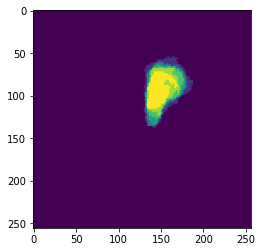

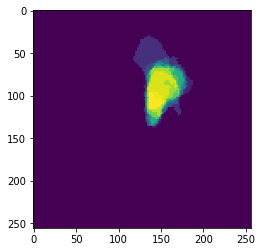

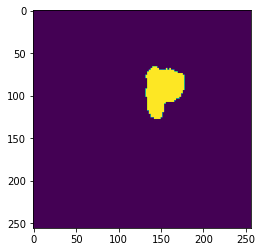

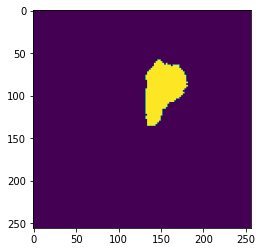

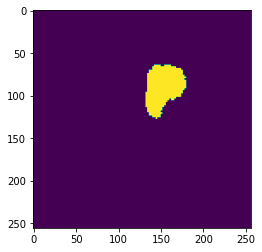

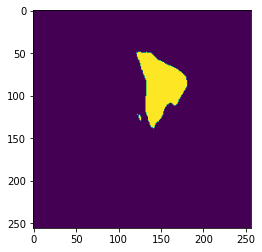

In [30]:
plt.imshow(dp_overlay)
plt.show()
plt.imshow(staple_overlay)
plt.show()
plt.imshow(expert_label)
plt.show()
plt.imshow(staple_consensus)
plt.show()
plt.imshow(dp_consensus)
plt.show()
plt.imshow(prediction)
plt.show()
